In [1]:
import sys
import os
import json
from shapely.geometry import shape
import numpy as np
from dask.distributed import Client, LocalCluster
from pystac_client import Client as StacClient
import stackstac
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
cluster = LocalCluster(
    n_workers=4,             # safe for 15 GB RAM
    threads_per_worker=1,    # raster operations run best single-threaded
    memory_limit="6GB"       # 3 workers × 4GB = 12GB used
)

client = Client(cluster)
cluster


LocalCluster(d5c2475b, 'tcp://127.0.0.1:39887', workers=4, threads=4, memory=22.35 GiB)

In [7]:
# Add the folder containing WQI_utils.py
sys.path.append(os.path.abspath("../utils"))

# Import the main functions
from WQI_utils import compute_wqi_indices
from plots_utils import (
    plot_wqi_time_series, 
    plot_wqi_seasonal, 
    plot_wqi_seasons, 
    plot_wqi_pie_charts  
)

In [8]:
TAMPA_BAY = (-82.7167, 27.5833, -82.3833, 28.0333)

start_date = "2019-12-01"
end_date = "2024-12-31"

In [9]:
df_full, df_roll_full, monthly_full = compute_wqi_indices(
    bbox=TAMPA_BAY,
    start_date=start_date,
    end_date=end_date,
    max_items=100,           
    filter_clouds=True
)
print("Full Tampa_Bay results shape:", df_full.shape)
print("Stack ready for maps!")

Cloud filtered: 100 → 26 scenes (<20.0% cloud cover)

=== FULL DATA QUALITY DIAGNOSTICS (First 5 Scenes) ===

SCENE 1: 2024-12-23 | ID: S2B_17RL...
Thumbnail: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/17/R/LL/2024/12/S2B_17RLL_20241223_0_L2A/thumbnail.jpg
Cloud cover (metadata): 0.066426%


/opt/conda/envs/geog313-final-project/lib/python3.11/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


SCL breakdown: Clouds=0.2% | Water=48.8% | Valid=15,406,410px
Raw NDWI: -0.340 | Green: 610.678 | NIR: 1239.585
--------------------------------------------------------------------------------

SCENE 2: 2024-12-18 | ID: S2A_17RL...
Thumbnail: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/17/R/LL/2024/12/S2A_17RLL_20241218_0_L2A/thumbnail.jpg
Cloud cover (metadata): 17.235643%
SCL breakdown: Clouds=6.2% | Water=47.4% | Valid=15,406,410px
Raw NDWI: -0.304 | Green: 675.220 | NIR: 1266.070
--------------------------------------------------------------------------------

SCENE 3: 2024-12-13 | ID: S2B_17RL...
Thumbnail: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/17/R/LL/2024/12/S2B_17RLL_20241213_0_L2A/thumbnail.jpg
Cloud cover (metadata): 0.126712%
SCL breakdown: Clouds=0.4% | Water=48.5% | Valid=15,406,410px
Raw NDWI: -0.343 | Green: 646.816 | NIR: 1322.153
--------------------------------------------------------------------------------

S

In [10]:
print("TAMPA_BAY FULL results shape:", df_full.shape)
print(df_full.head())
print("\nColumns:", df_full.columns.tolist())
print("\nRolling shape:", df_roll_full.shape)
print(monthly_full.round(3))

TAMPA_BAY FULL results shape: (26, 7)
                         ndwi_mean  ndwi_median  ndti_mean  ndti_median  \
date                                                                      
2024-05-02 16:15:35.287   0.098388    -0.033447  -0.102072    -0.050302   
2024-05-02 16:15:49.847   0.261430     0.392000  -0.192573    -0.231018   
2024-05-07 16:15:33.233   0.050712    -0.038468  -0.072969    -0.038613   
2024-05-07 16:15:47.787   0.201422     0.300813  -0.153723    -0.174419   
2024-05-22 16:15:31.815   0.127993     0.303634  -0.103197    -0.149580   

                         ndci_mean  ndci_median  month  
date                                                    
2024-05-02 16:15:35.287   0.035158     0.003051      5  
2024-05-02 16:15:49.847   0.018867    -0.001641      5  
2024-05-07 16:15:33.233   0.049480     0.015555      5  
2024-05-07 16:15:47.787   0.024562     0.004791      5  
2024-05-22 16:15:31.815   0.030439    -0.002169      5  

Columns: ['ndwi_mean', 'ndwi_median'

In [11]:
results_dir = "data/processed"
os.makedirs(results_dir, exist_ok=True)

df_full.to_csv(os.path.join(results_dir, "indices_results.csv"))
df_roll_full.to_csv(os.path.join(results_dir, "indices_rolling.csv"))
monthly_full.to_csv(os.path.join(results_dir, "indices_monthly.csv"))


In [ ]:
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../")) 
results_dir = os.path.join(project_root, "results")

os.makedirs(results_dir, exist_ok=True)

df_full.to_csv(os.path.join(results_dir, "TAMPA_BAY_results.csv"))
df_roll_full.to_csv(os.path.join(results_dir, "TAMPA_BAY_rolling.csv"))
monthly_full.to_csv(os.path.join(results_dir, "TAMPA_BAY_monthly.csv"))

print("Saved processed outputs in:", os.path.abspath(results_dir))


## Plotting Time Series (Mean and Median)

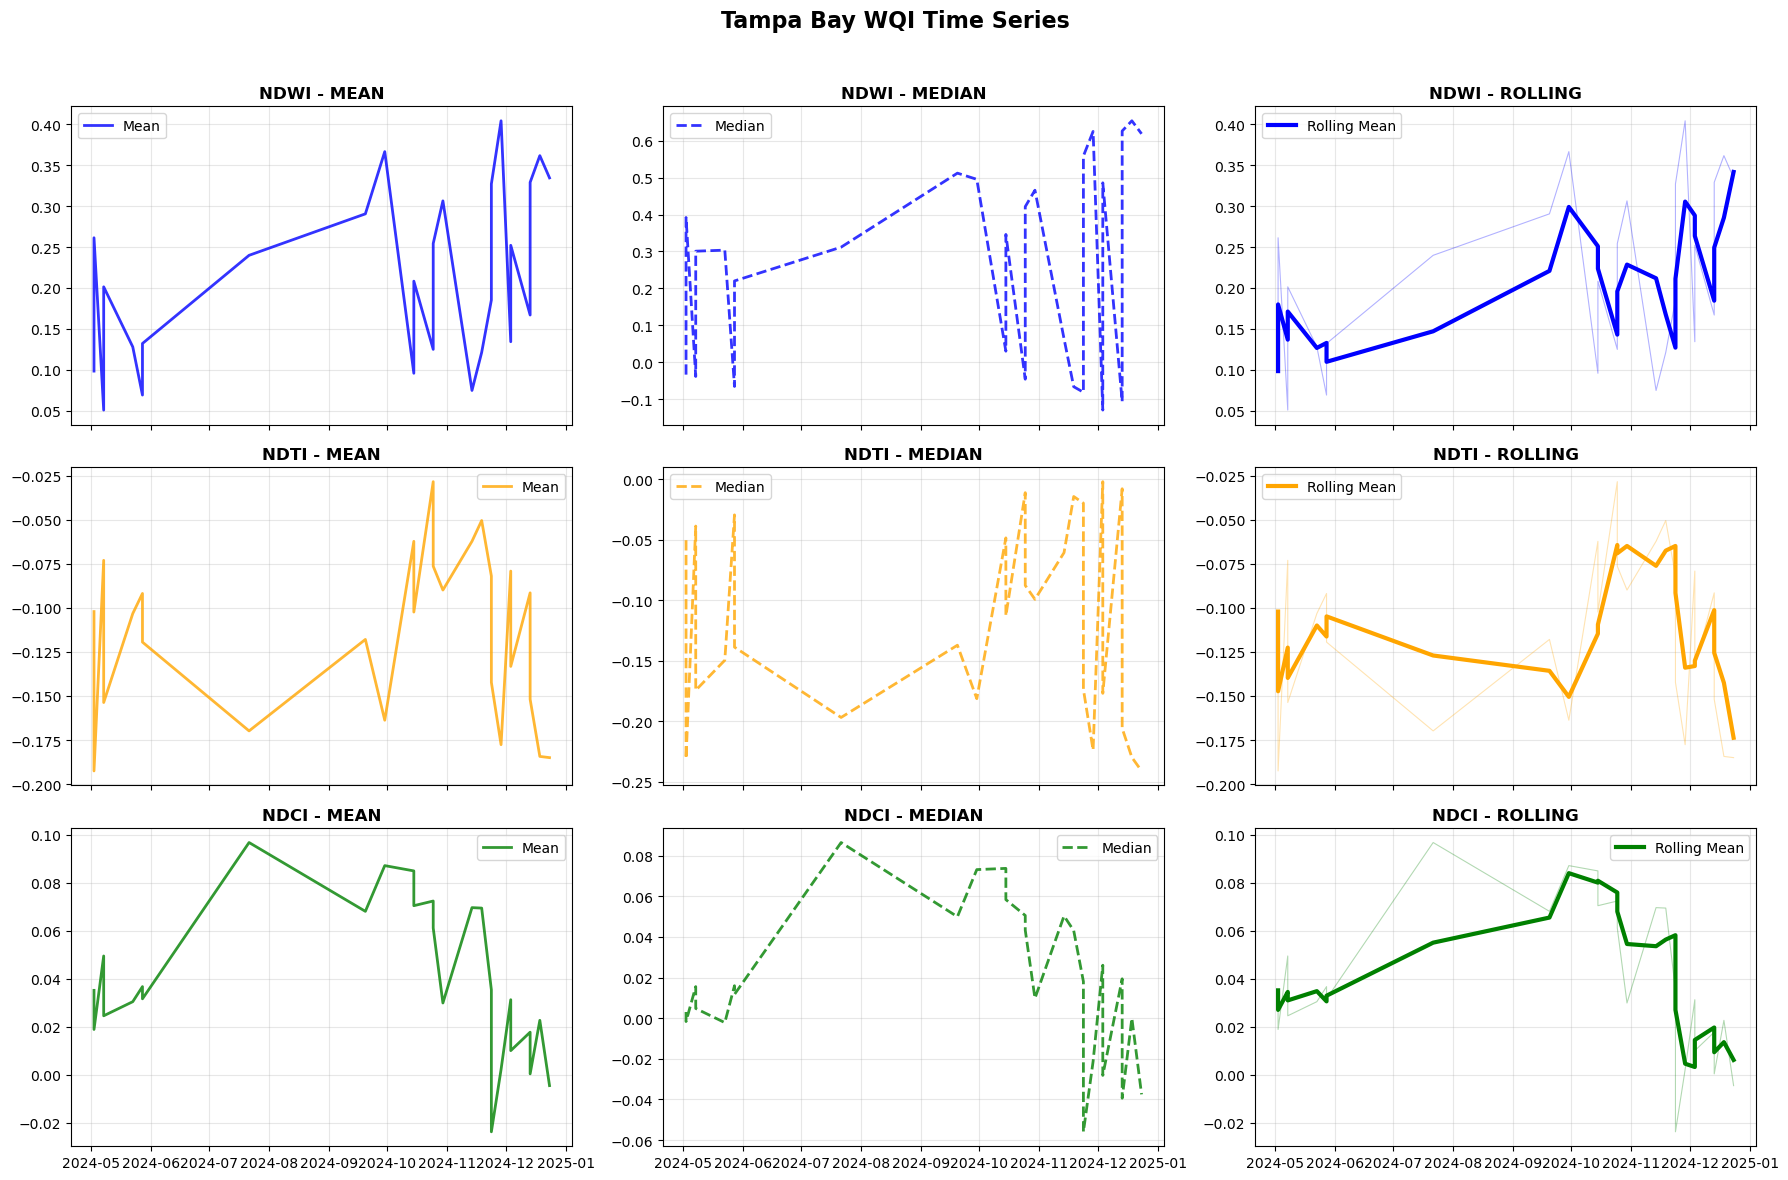

In [12]:
plot_wqi_time_series(df_full, df_roll_full, title="Tampa Bay WQI Time Series")

## Plotting Seasonal Cycle (Mean and Median)

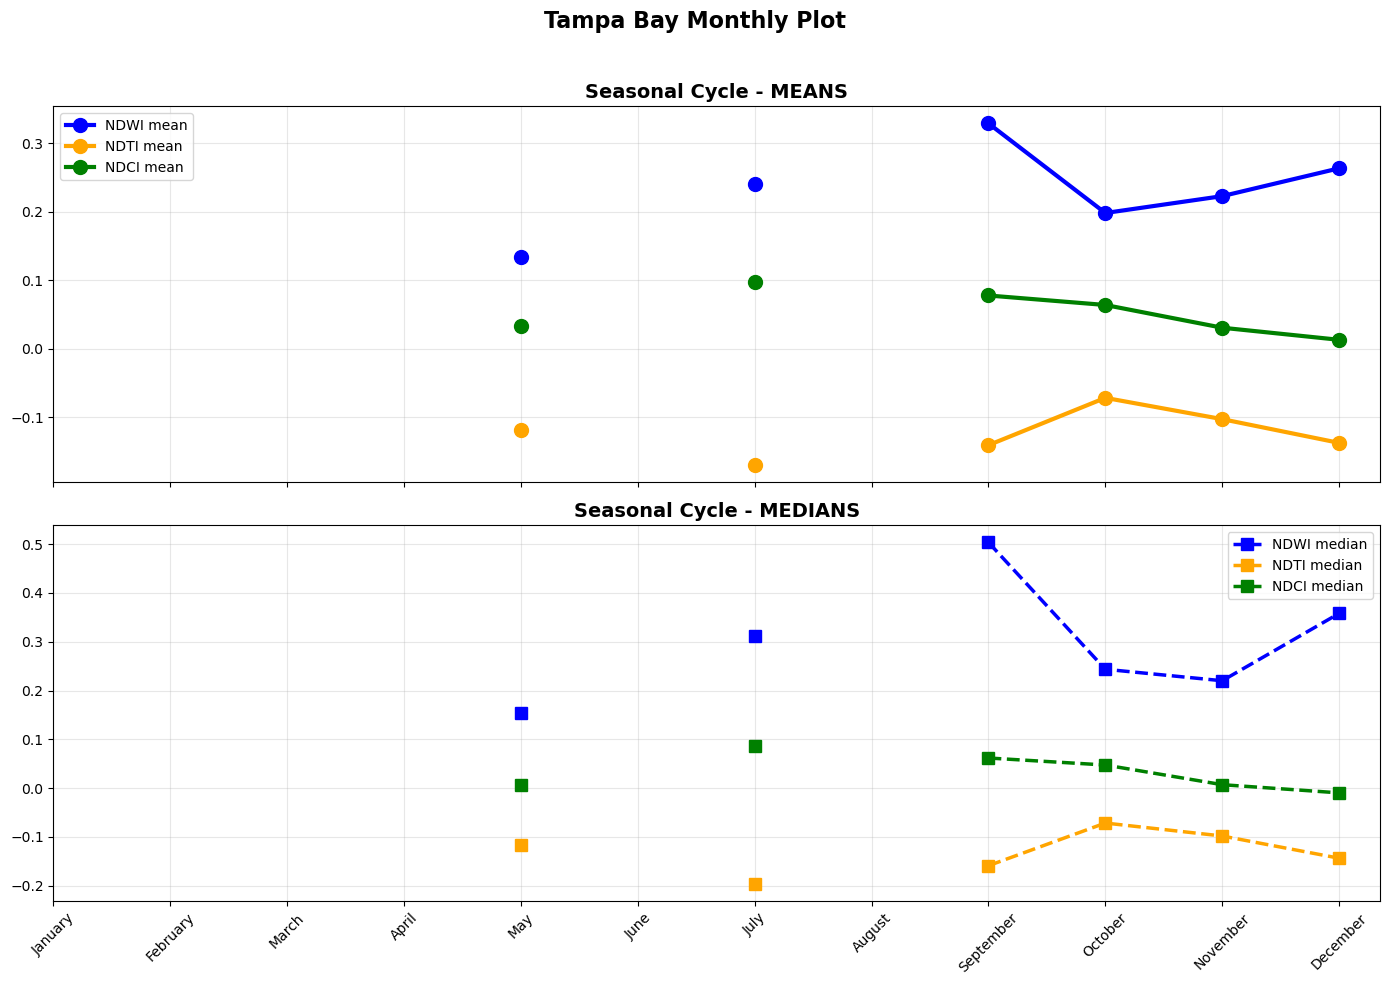

In [14]:
plot_wqi_seasonal(monthly_full, title="Tampa Bay Monthly Plot")

## Plotting Seasons (Mean)

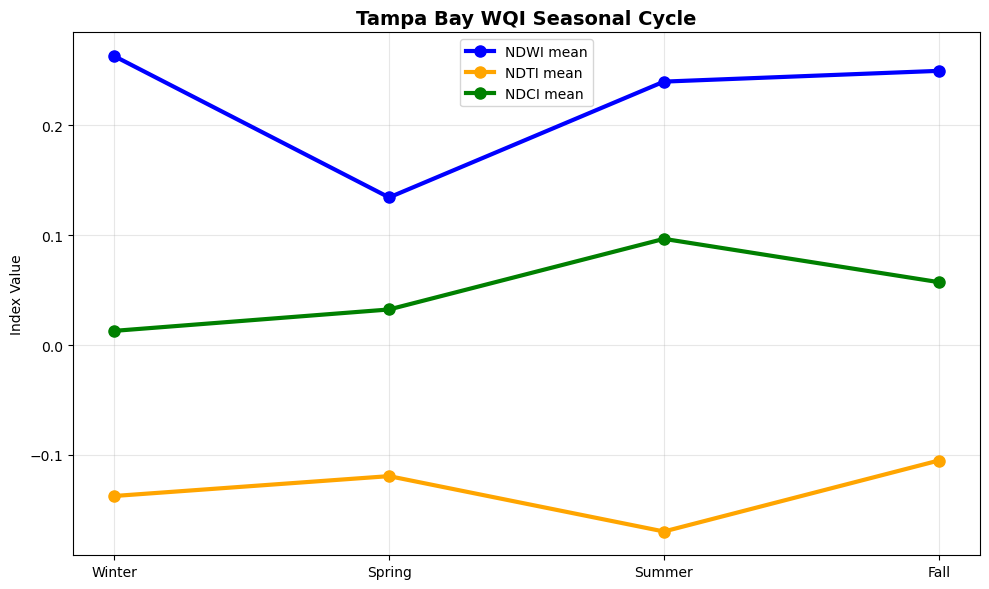

In [15]:
# Indexing to Datetime
monthly_full.index = pd.to_datetime(monthly_full.index, format='%B')

plot_wqi_seasons(monthly_full, title="Tampa Bay WQI Seasonal Cycle")

## Generating Pie Chat to Identify Water Quality State

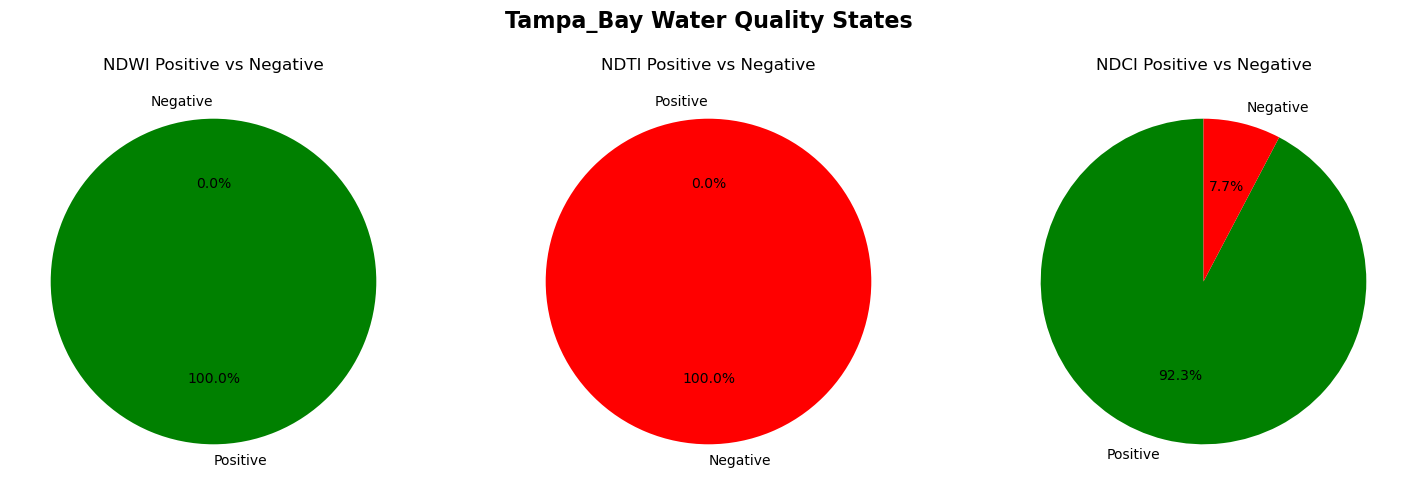

In [17]:
plot_wqi_pie_charts(df_full, title="Tampa_Bay Water Quality States")

In [18]:
# Save all the main plots to the outputs folder
# Save plots to results folder (folder already exists)
plt.savefig(os.path.join(results_dir, "Tampa_Bay_Water_Quality_States.png"))
plt.savefig(os.path.join(results_dir, "Tampa_Bay_WQI_Seasonal_Cycle_Seasons.png"))
plt.savefig(os.path.join(results_dir, "Tampa_Bay_WQI_Seasonal_Cycle_12Months.png"))
plt.savefig(os.path.join(results_dir, "Tampa_Bay_WQI_Time_Series.png"))

print("Saved all plots to results folder:", os.path.abspath(results_dir))

Saved all plots to results folder: /home/jupyteruser/scr/notebooks/data/processed


<Figure size 640x480 with 0 Axes>